## Language Translator

In [5]:
import nltk

From `nltk` we can download translated sentences between different languages. You can see the example between **English and French** below but feel free to try different combination as well.

In [7]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import preprocessing
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM, Reshape, GRU, Dropout, \
TimeDistributed
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.losses import sparse_categorical_crossentropy

import numpy as np
import pandas as pd

import collections

import scipy.stats as stats
import pylab as plt

In [8]:
nltk.download('comtrans')

[nltk_data] Downloading package comtrans to /home/emile/nltk_data...
[nltk_data]   Package comtrans is already up-to-date!


True

In [9]:
from nltk.corpus import comtrans
print(comtrans.aligned_sents('alignment-en-fr.txt')[0])

<AlignedSent: 'Resumption of the se...' -> 'Reprise de la sessio...'>


In [10]:
len(comtrans.aligned_sents('alignment-en-fr.txt'))

33334

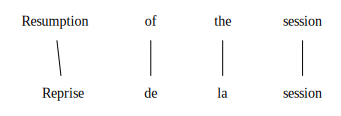

In [11]:
comtrans.aligned_sents('alignment-en-fr.txt')[0]

In [12]:
words = comtrans.words('alignment-en-fr.txt')

In [13]:
for word in words[:20]:
    print(word)

Resumption
of
the
session
I
declare
resumed
the
session
of
the
European
Parliament
adjourned
on
Friday
17
December
1999
,


In [14]:
als_0 = comtrans.aligned_sents("alignment-en-fr.txt")[0]
als_0

print(" ".join(als_0.words))
print(" ".join(als_0.mots))

Resumption of the session
Reprise de la session


In [15]:
als_0.alignment

Alignment([(0, 0), (1, 1), (2, 2), (3, 3)])

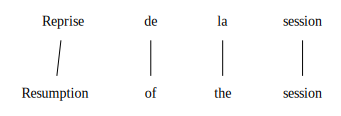

In [16]:
als_0.invert()

In [17]:
from nltk.translate import Alignment, AlignedSent

In [18]:
# creating own alignments, no need though?
als = AlignedSent( ["Reprise", "de", "la", "session" ], \
    ["Resumption", "of", "the", "session" ] , \
    Alignment( [ (0 , 0), (1 , 1), (2 , 2), (3 , 3) ] ) )

# Parsing

In [20]:
als_0.mots

['Reprise', 'de', 'la', 'session']

In [21]:
als = comtrans.aligned_sents('alignment-en-fr.txt')

## French

In [22]:
french_words = []
for i in range(len(als)):
    for word in als[i].mots:
        french_words.append(word)

In [23]:
print(len(french_words))

734360


In [24]:
french_words = [word.lower() for word in french_words]
set_french = set(french_words)

In [25]:
len(set_french)

22819

In [26]:
french_sentences = []
for i in range(len(als)):
    sent = ' '.join(als[i].mots)
    french_sentences.append(sent)

In [27]:
french_sentences[0]

'Reprise de la session'

In [78]:
len(french_sentences)

33334

## English

In [28]:
english_words = []
for i in range(len(als)):
    for word in als[i].words:
        english_words.append(word)

In [29]:
english_words = [word.lower() for word in english_words]
set_english = set(english_words)

In [30]:
len(set_english)

17075

In [31]:
english_sentences = []
for i in range(len(als)):
    sent = ' '.join(als[i].words)
    english_sentences.append(sent)

In [32]:
english_sentences[0]

'Resumption of the session'

In [79]:
len(english_sentences)

33334

# Preprocess

In [33]:
def tokenize(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

In [34]:
example_sentences = english_sentences[:3]
example_sentences

['Resumption of the session',
 'I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999 , and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period .',
 'You have requested a debate on this subject in the course of the next few days , during this part-session .']

In [35]:
text_tokenized, text_tokenizer = tokenize(example_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(example_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input: {}'.format(sent))
    print('  Ouput: {}'.format(token_sent))

{'the': 1, 'of': 2, 'session': 3, 'you': 4, 'a': 5, 'i': 6, 'on': 7, 'in': 8, 'this': 9, 'resumption': 10, 'declare': 11, 'resumed': 12, 'european': 13, 'parliament': 14, 'adjourned': 15, 'friday': 16, '17': 17, 'december': 18, '1999': 19, 'and': 20, 'would': 21, 'like': 22, 'once': 23, 'again': 24, 'to': 25, 'wish': 26, 'happy': 27, 'new': 28, 'year': 29, 'hope': 30, 'that': 31, 'enjoyed': 32, 'pleasant': 33, 'festive': 34, 'period': 35, 'have': 36, 'requested': 37, 'debate': 38, 'subject': 39, 'course': 40, 'next': 41, 'few': 42, 'days': 43, 'during': 44, 'part': 45}

Sequence 1 in x
  Input: Resumption of the session
  Ouput: [10, 2, 1, 3]
Sequence 2 in x
  Input: I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999 , and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period .
  Ouput: [6, 11, 12, 1, 3, 2, 1, 13, 14, 15, 7, 16, 17, 18, 19, 20, 6, 21, 22, 23, 24, 25, 26, 4, 5, 27, 28, 29, 8

### Need to tokenize the everything. Will have to use this function to tokenize english_sentences and french_sentences

In [36]:
english_text_tokenized, english_text_tokenizer = tokenize(english_sentences)

In [37]:
french_text_tokenized, french_text_tokenizer = tokenize(french_sentences)

# Padding

In [38]:
def pad(x, length=None):
    return pad_sequences(x, maxlen=length, padding='post')

In [39]:
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))    

Sequence 1 in x
  Input:  [10  2  1  3]
  Output: [10  2  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Sequence 2 in x
  Input:  [ 6 11 12  1  3  2  1 13 14 15  7 16 17 18 19 20  6 21 22 23 24 25 26  4
  5 27 28 29  8  1 30 31  4 32  5 33 34 35]
  Output: [ 6 11 12  1  3  2  1 13 14 15  7 16 17 18 19 20  6 21 22 23 24 25 26  4
  5 27 28 29  8  1 30 31  4 32  5 33 34 35]
Sequence 3 in x
  Input:  [ 4 36 37  5 38  7  9 39  8  1 40  2  1 41 42 43 44  9 45  3]
  Output: [ 4 36 37  5 38  7  9 39  8  1 40  2  1 41 42 43 44  9 45  3  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


### Need to tokenize both english and french sentences

In [40]:
pad_english = pad(english_text_tokenized)

In [41]:
pad_french = pad(french_text_tokenized)

# Preprocess pipeline

In [42]:
# reducing max length
def pad(x, length=20):
    return pad_sequences(x, maxlen=length, padding='post')

In [43]:
def preprocess(x, y):
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)
    
    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)
    
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)
    
    return preprocess_x, preprocess_y, x_tk, y_tk

In [44]:
preproc_english_sentences, preproc_french_sentences, \
english_tokenizer, french_tokenizer = preprocess(english_sentences, french_sentences)

In [45]:
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

In [46]:
print('Max English sentence length:', max_english_sequence_length)
print('Max French sentence length:', max_english_sequence_length)
print('English vocabulary size: ', english_vocab_size)
print('French vocabulary size: ', french_vocab_size)

Max English sentence length: 20
Max French sentence length: 20
English vocabulary size:  15930
French vocabulary size:  21870


# Modeling

In [47]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenier.word_index.items()}
    index_to_words[0] = '<PAD>'
    
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits,1)])

# RNN

In [69]:
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.

config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)

In [76]:
def model(input_shape, output_sequence_length, english_vocab_size,
         french_vocab_size):
    learning_rate = 0.005
    # layers
    model = Sequential()
    model.add(GRU(256, input_shape=input_shape[1:], return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))
    
    # compile
    model.compile(loss=sparse_categorical_crossentropy,
                 optimizer=Adam(learning_rate),
                 metrics=['accuracy'])
    return model

In [75]:
# reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
print(tmp_x.shape)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
print(tmp_x.shape)

(33334, 20)
(33334, 20, 1)


In [74]:
tmp_x.shape

(33334, 20, 1)

In [73]:
max_french_sequence_length

20

In [72]:
# train
rnn_model = model(tmp_x.shape, max_french_sequence_length, english_vocab_size,
                 french_vocab_size)

In [71]:
print(rnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 20, 256)           198144    
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 1024)          263168    
_________________________________________________________________
dropout (Dropout)            (None, 20, 1024)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 21870)         22416750  
Total params: 22,878,062
Trainable params: 22,878,062
Non-trainable params: 0
_________________________________________________________________
None


In [77]:
rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=2, epochs=10,
              validation_split=0.2)

Train on 26667 samples, validate on 6667 samples
Epoch 1/10


AlreadyExistsError: Resource __per_step_22/training/gradients/AddN_5/tmp_var/N10tensorflow19TemporaryVariableOp6TmpVarE
	 [[{{node training/gradients/AddN_5/tmp_var}}]]